In [ ]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib
from collections import namedtuple
import datetime
from scipy.spatial import KDTree
import contextily as cx

In [41]:
# define csv file paths
# Monte Carlo crime simulation
mc_csv = "C:/Users/matth/Documents/GTECH/Fall 2021/Geocomp2/Week5/MC_output_5_to_200.csv"
# NYC crime data from 2019
csv = csv_source = 'C:/Users/matth/Documents/GTECH/Fall 2021/Geocomp2/Week5/NYPDIncidentLevelData/NYPD_Complaint_Map__Historic_2019.csv'

In [2]:
def process_crime_data(csv)
# only read in columns for date/time, crime description, xy coordinates
    df = pd.read_csv(csv, usecols=[1, 2, 3, 4, 8, 19, 20], low_memory=False)
# print(df.columns)
# print(df.dtypes)
# recast date/time columnes to datetime dtype and xy coordinates to int64 dtype
# first get commas out of xy coordinate data
    df['X_COORD_CD'] = df['X_COORD_CD'].str.replace(',', '')
    df['Y_COORD_CD'] = df['Y_COORD_CD'].str.replace(',', '')
# find NaN values in xy columns and remove
    df = df.dropna()
# print(df)
# combine date and time columns
    df['C_FR_DATE'] = df['CMPLNT_FR_DT'] + ' ' + df['CMPLNT_FR_TM']
    df['C_TO_DATE'] = df['CMPLNT_TO_DT'] + ' ' + df['CMPLNT_TO_TM']
# convert date columns to datetime
    df['C_FR_DATE'] = pd.to_datetime(df['C_FR_DATE'])
    df['C_TO_DATE'] = pd.to_datetime(df['C_TO_DATE'])
# print(df['C_FR_DATE'])
# convert xy columns to integers
    df['X_COORD_CD'] = df['X_COORD_CD'].astype('int64')
    df['Y_COORD_CD'] = df['Y_COORD_CD'].astype('int64')
# create geometry point objects based on xy coordinates
    geometry = [Point(xy) for xy in zip(df.X_COORD_CD, df.Y_COORD_CD)]
# create crs of state plane long island
    crs = 'epsg:2263'
# create geodataframe
    geo_df = GeoDataFrame(df, crs=crs, geometry=geometry)
# geo_df.plot("OFNS_DESC")
    # create a dataframe of larceny crimes
    lar_df = geo_df.loc[(geo_df["OFNS_DESC"] == "GRAND LARCENY") | (geo_df["OFNS_DESC"] == "GRAND LARCENY OF A MOTOR VEHICLE") | (geo_df["OFNS_DESC"] == "THEFT-FRAUD")]
# calculate geographic bounds of lar_df to keep basemap static in plotting
# print(lar_df.total_bounds)
    xleft = lar_df.total_bounds[0]
    xright = lar_df.total_bounds[2]
    yleft = lar_df.total_bounds[1]
    yright = lar_df.total_bounds[3]
    return lar_df, xleft, xright, yleft, yright

<AxesSubplot:>

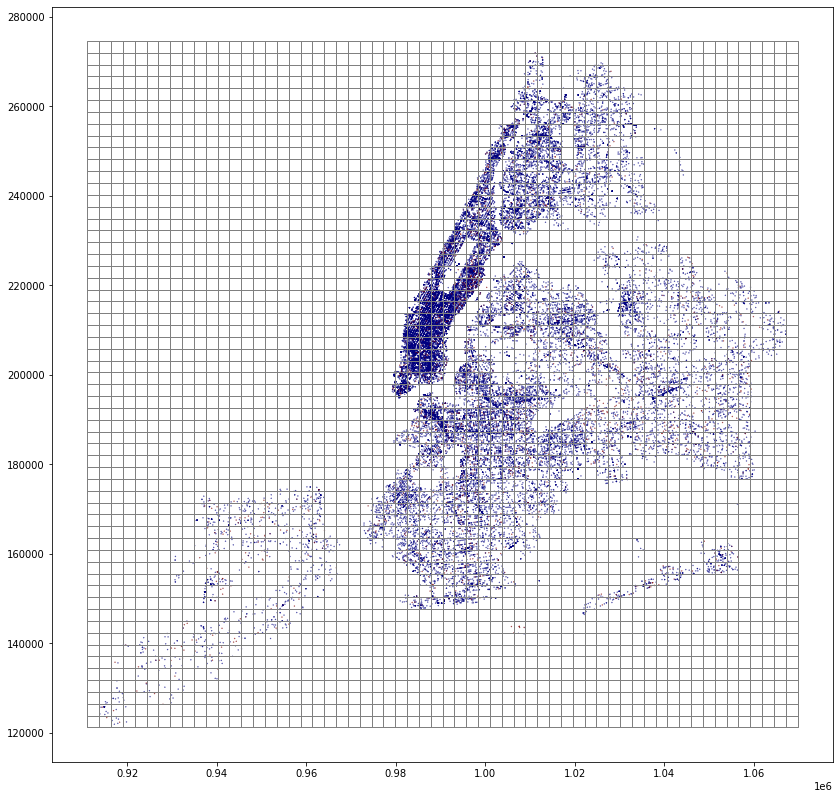

In [7]:
# plot the crimes and the grid
ax = lar_df.plot(markersize=.1, figsize = (14,14), column='OFNS_DESC', cmap='jet')
grid.plot(ax=ax, facecolor="none", edgecolor="grey")

In [ ]:
# Create two new geodataframes. Each will span one month (30 days) of time to see if there are differenes in
# likelihoods of crime based on two different times of year (winter and summer)
# Time periods will be Jan 15 - Feb 15, 2019 and June 15 - July 15, 2019
# (https://stackoverflow.com/questions/22898824/filtering-pandas-dataframes-on-dates)
# winter = geo_df[(geo_df['C_FR_DATE'] > '2019-01-14') & (geo_df['C_FR_DATE'] < '2019-02-16')]
# summer = geo_df[(geo_df['C_FR_DATE'] > '2019-06-14') & (geo_df['C_FR_DATE'] < '2019-07-16')]

In [5]:
def create_grid_domains(geo_df)
# Create a polygon grid of 1/2x1/2 mile to determine the centroids of the domain space cylinders
# (https://james-brennan.github.io/posts/fast_gridding_geopandas/)
    xmin, ymin, xmax, ymax = geo_df.total_bounds
    cell_size = (xmax-xmin)/58
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

# copy original grid and add a probability column to the new grid spaces
    grid_prob = grid.copy()
    
# create a 'centroid' from each grid square in a copy of the grid dataframe
    ds = grid.copy()
# create centroids
    ds['centroid'] = ds.centroid
# create 1/2 mile (2640 feet) buffer around each centroid
    ds['domain_space'] = ds['centroid'].buffer(2640)
# make a new geodataframe of just the centroid-based buffers (domain space)
    domain_spaces = GeoDataFrame(ds, crs=crs, geometry=ds['domain_space'])
#spatial join of crime points that fall within the domain spaces
    domains = gpd.sjoin(geo_df, domain_spaces)
# sort the domains geodataframe by the 'index_right' value, which is a unique value 
# for each domain cylinder
    domains_sort = domains.sort_values(by=['index_right'])
# create copy of sorted domains for further processing    
    d2 = domains_sort.copy()
    return d2

<AxesSubplot:>

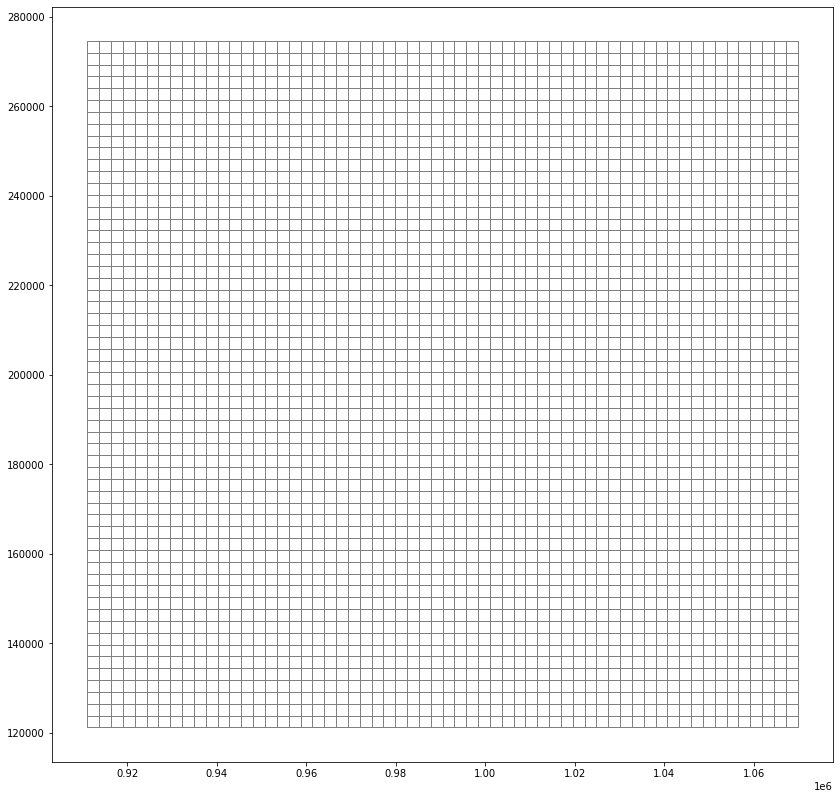

In [9]:
# make sure original grid is still intact (will be used later to have colored in squares
# where there is siginificant crime risk)
grid.plot(markersize=.1, figsize = (14, 14), facecolor="none", edgecolor="grey")

In [12]:
#spatial join of crime points that fall within the domain spaces
domains = gpd.sjoin(geo_df, domain_spaces)

<AxesSubplot:>

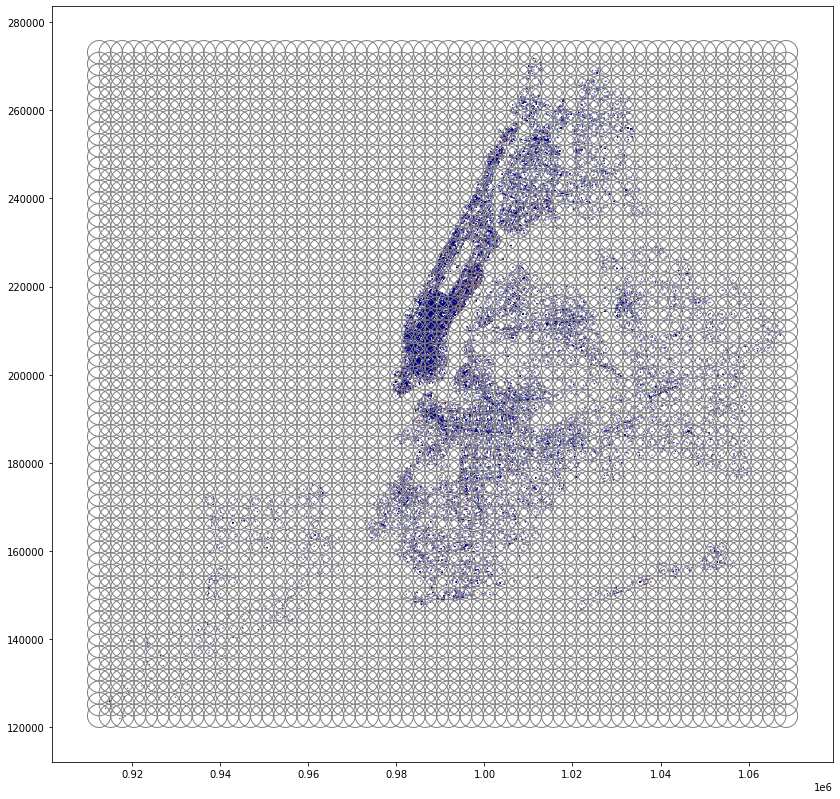

In [13]:
# plot the crimes and the domains
ax = lar_df.plot(markersize=.1, figsize = (14,14), column='OFNS_DESC', cmap='jet')
domain_spaces.plot(ax=ax, facecolor="none", edgecolor="grey")

In [25]:
cr = domains.dissolve(by="CMPLNT_FR_DT", aggfunc="count")

In [27]:
cr.describe()

,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,OFNS_DESC,X_COORD_CD,Y_COORD_CD,C_FR_DATE,C_TO_DATE,centroid,domain_space
count,1316.000000,1316.000000,1316.000000,1316.000000,1316.000000,1316.000000,1316.000000,1316.000000,1316.000000,1316.000000,1316.000000
mean,95.044073,95.044073,95.044073,95.044073,95.044073,95.044073,95.044073,95.044073,95.044073,95.044073,95.044073
std,163.429680,163.429680,163.429680,163.429680,163.429680,163.429680,163.429680,163.429680,163.429680,163.429680,163.429680
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
50%,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
75%,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
max,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000


In [15]:
# print the number of unique domains containing points
print(len(np.unique(domains_sort['index_right'])))

1316


In [44]:
print(domains_sort.columns)

Index(['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM',
       'OFNS_DESC', 'X_COORD_CD', 'Y_COORD_CD', 'C_FR_DATE', 'C_TO_DATE',
       'geometry', 'index_right', 'centroid', 'domain_space'],
      dtype='object')


In [16]:
# create copy of domains_sort without duplicates of geometry
# this is done because many of the crimes are simply reported as having x/y coordinates
# at the precinct offices, which would lead to inaccurate spatiotemporal analysis
# d2 = domains_sort.drop_duplicates(subset = ['geometry'])
d2 = domains_sort.copy()

In [25]:
d2

,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,OFNS_DESC,X_COORD_CD,Y_COORD_CD,C_FR_DATE,C_TO_DATE,geometry,index_right,centroid,domain_space
163045,8/29/2019,15:00:00,8/29/2019,15:05:00,GRAND LARCENY,913912,124185,2019-08-29 15:00:00,2019-08-29 15:05:00,POINT (913912.000 124185.000),0,POINT (912461.578 122474.422),"POLYGON ((915101.578 122474.422, 915088.865 12..."
423173,2/6/2019,13:09:00,2/6/2019,13:20:00,GRAND LARCENY,914928,125757,2019-02-06 13:09:00,2019-02-06 13:20:00,POINT (914928.000 125757.000),1,POINT (912461.578 125119.267),"POLYGON ((915101.578 125119.267, 915088.865 12..."
412281,1/22/2019,0:01:00,2/5/2019,13:20:00,THEFT-FRAUD,914444,125683,2019-01-22 00:01:00,2019-02-05 13:20:00,POINT (914444.000 125683.000),1,POINT (912461.578 125119.267),"POLYGON ((915101.578 125119.267, 915088.865 12..."
394324,2/25/2019,20:30:00,2/25/2019,21:30:00,GRAND LARCENY,914159,125680,2019-02-25 20:30:00,2019-02-25 21:30:00,POINT (914159.000 125680.000),1,POINT (912461.578 125119.267),"POLYGON ((915101.578 125119.267, 915088.865 12..."
338094,4/12/2019,10:00:00,4/13/2019,10:00:00,GRAND LARCENY,914928,125757,2019-04-12 10:00:00,2019-04-13 10:00:00,POINT (914928.000 125757.000),1,POINT (912461.578 125119.267),"POLYGON ((915101.578 125119.267, 915088.865 12..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387448,3/9/2019,18:30:00,3/9/2019,18:36:00,GRAND LARCENY,1067185,209005,2019-03-09 18:30:00,2019-03-09 18:36:00,POINT (1067185.000 209005.000),3455,POINT (1068507.422 209754.302),"POLYGON ((1071147.422 209754.302, 1071134.710 ..."
100495,5/28/2019,8:00:00,10/2/2019,16:00:00,GRAND LARCENY,1066675,211090,2019-05-28 08:00:00,2019-10-02 16:00:00,POINT (1066675.000 211090.000),3456,POINT (1068507.422 212399.147),"POLYGON ((1071147.422 212399.147, 1071134.710 ..."
370200,3/16/2019,20:00:00,3/17/2019,8:00:00,GRAND LARCENY,1066768,212190,2019-03-16 20:00:00,2019-03-17 08:00:00,POINT (1066768.000 212190.000),3456,POINT (1068507.422 212399.147),"POLYGON ((1071147.422 212399.147, 1071134.710 ..."
28380,11/11/2019,13:00:00,12/10/2019,15:00:00,GRAND LARCENY,1066083,212686,2019-11-11 13:00:00,2019-12-10 15:00:00,POINT (1066083.000 212686.000),3456,POINT (1068507.422 212399.147),"POLYGON ((1071147.422 212399.147, 1071134.710 ..."


In [ ]:
# create a list of the crimes within each domain space
# tree_list = []
# for domain in np.unique(d2['index_right']):
#     points = d2.loc[d2['index_right'] == domain]
#     tree_list.append(points)

In [17]:
def space_time_dictionary(d2)
# create dictionaries of the crime xy coords and times with keys of the domain space indices
# (which are tied back to the indices of the grid squares)
kd_s_dict = {}
# kd_t_dict = {}
k = np.unique(d2['index_right'])

for each in k:
#     print(d2[d2['index_right']==each])
    kd_s_dict[each] = d2[d2['index_right']==each]

In [ ]:
# create lists of the crime xy coords and times
# kd_s_list = []
# kd_t_list = []
# for domain in tree_list:
#     xy = np.column_stack((domain['X_COORD_CD'], domain['Y_COORD_CD']))
#     t = domain['C_FR_DATE']
#     kd_s_list.append(xy)
#     kd_t_list.append(t)

In [ ]:
# # spatial join of crime points to each grid cell
# merged = gpd.sjoin(geo_df, grid, how='left', predicate='within')
# # dissolve crime point data and create count of total crime points per grid cell
# merged['n_crimes'] = 1
# cbt = merged[['OFNS_DESC', 'C_FR_DATE', 'C_TO_DATE', 'geometry', 'index_right', 'n_crimes']]
# dissolve = cbt.dissolve(by="index_right", aggfunc="count")
# grid.loc[dissolve.index, 'n_crimes'] = dissolve.n_crimes.values
# # print(dissolve.head())

In [ ]:
# same thing for winter
# merged_win = gpd.sjoin(winter, grid_win, how='left', predicate='within')
# merged_win['n_crimes'] = 1
# cbt_win = merged_win[['OFNS_DESC', 'C_FR_DATE', 'C_TO_DATE', 'geometry', 'index_right', 'n_crimes']]
# dissolve_win = cbt_win.dissolve(by="index_right", aggfunc="count")
# grid_win.loc[dissolve_win.index, 'n_crimes'] = dissolve_win.n_crimes.values
# grid_win = grid_win[grid_win['n_crimes']>0]

In [ ]:
# same thing for summer
# merged_sum = gpd.sjoin(summer, grid_sum, how='left', predicate='within')
# merged_sum['n_crimes'] = 1
# cbt_sum = merged_sum[['OFNS_DESC', 'C_FR_DATE', 'C_TO_DATE', 'geometry', 'index_right', 'n_crimes']]
# dissolve_sum = cbt_sum.dissolve(by="index_right", aggfunc="count")
# grid_sum.loc[dissolve_sum.index, 'n_crimes'] = dissolve_sum.n_crimes.values
# grid_sum = grid_sum[grid_sum['n_crimes']>0]

In [ ]:
# plot the grid with the number of crimes in each grid cell
# ax = grid.plot(column='n_crimes', figsize=(14,14), cmap='viridis', edgecolor='grey')
# grid.plot(ax=ax, facecolor="none", edgecolor="grey")

In [ ]:
# plot for winter
# ax = grid_win.plot(column='n_crimes', figsize=(14,14), cmap='viridis', edgecolor='grey')
# grid.plot(ax=ax, facecolor="none", edgecolor="grey")

In [ ]:
# plot for summer
# ax = grid_sum.plot(column='n_crimes', figsize=(14,14), cmap='viridis', edgecolor='grey')
# grid.plot(ax=ax, facecolor="none", edgecolor="grey")

In [ ]:
# # create a new 'centroid' column for each month crime merged dataframe (merged_***)
# # first create centroids in grid_win dataframe
# grid_win['centroid'] = grid_win.centroid
# # create 1.5 mile (7920 feet) buffer around each centroid
# grid_win['domain_space'] = grid_win['centroid'].buffer(7920)
# # spatial join of merged_win to grid_win based on points falling within the domain space
# # first make a new geodataframe of just the centroid-based buffers (domain space)
# domain_spaces_win = GeoDataFrame(grid_win['n_crimes'], crs=crs, geometry=grid_win['domain_space'])
# # clean up merged win to prepare for spatial join to domain space dataframe
# merged_win_new = merged_win[['OFNS_DESC', 'C_FR_DATE', 'geometry']]
# # spatial join of crime points data to domain space grid
# merged_grid_win = gpd.sjoin(merged_win_new, domain_spaces_win, how='left', predicate='within')
# # create a column showing the difference in time (as a timedelta64 object)
# start_time = pd.to_datetime("2019-02-16") #winter start time
# merged_grid_win['time_dif'] = start_time - merged_grid_win['C_FR_DATE']
# # create a column to show the number of hours the crime occurred before the end of the month
# merged_grid_win['hours'] = merged_grid_win['time_dif'] / np.timedelta64(1, 'h')
# #create a new dataframe of only the data we need
# geo_win = merged_grid_win[['index_right', 'OFNS_DESC', 'geometry', 'hours']]
# # create a dictionary of geodataframes so we have each domain space and all the crimes points within.
# geo_dict_win = {k: v for k, v in geo_win.groupby('index_right')}

In [ ]:
# function to count the number of hours before a given start time
# def calc_hours_before(start_time, times):
#     #start_time must be in a string format like "YYYY-MM-DD"
#     hours = []
#     start = pd.to_datetime(start_time)
#     for time in times:
#         difference = start - time
# #         print(difference)
#         hd = difference / np.timedelta64(1, 'h')
#         hours.append(hd)
#     return hours
# a negative number is how many hours after the start date a crime occurred (i.e we're not interested in this crime as it
# is not in the current spatiotemporal domain). Hours of temporal interest are those values in between 0 and 504 inclusive.
# These are crimes that occured right at the start date or up to 21 days before.

In [18]:
# function to count the number of hours before a given start time
def calc_hours_before(start_time, d):
    hours = {}
    start = pd.to_datetime(start_time)
    for each in d:
        td = start - d[each]['C_FR_DATE']
        hd = td / np.timedelta64(1, 'h')
        hours[each] = hd
    return hours

In [25]:
t = close_S_T_ST(kd_s_dict, 1320, 72, "2019-05-01")

In [ ]:
# example of how to reference a single coordinate in the dictionary
y = kd_s_dict[0]['X_COORD_CD'].index[1]
print(y)

In [19]:
def close_S_T_ST(st_dict, close_space, close_time, start_time):
    ll = 0
    ul = 504
    cst_d = {}
# get the hours before the start date for each record    
    all_t = calc_hours_before(start_time, st_dict)
    for key in st_dict:
        num_events = len(st_dict[key])
        dom_xy = np.zeros(shape = (num_events, 2))
        dom_t = np.zeros(shape = (num_events, 1))
        p = 0
        for i in all_t[key].index:
            if all_t[key][i] > ll and all_t[key][i] < ul:      
                dom_xy[p, 0] = st_dict[key]['X_COORD_CD'][i]
                dom_xy[p, 1] = st_dict[key]['Y_COORD_CD'][i]
                dom_t[p, 0] = all_t[key][i]
                p += 1
#         print(p)
        dom_xy = dom_xy[0:p]
        xy_stack = np.column_stack((dom_xy[:,0], dom_xy[:,1]))
#         print(xy_stack)
        kdt_xy = KDTree(xy_stack)
        dom_t = dom_t[0:p]
        t_arr = np.array(dom_t)
#         print(t_arr)
        kdt_t = KDTree(t_arr)
        qp_xy = kdt_xy.query_pairs(r=close_space)
        qp_t = kdt_t.query_pairs(r=close_time)
        cst = qp_xy.intersection(qp_t)     
#         print(cst)
        sum_cs = len(qp_xy)
        sum_ct = len(qp_t)
        sum_cst = len(cst)
        cst_d[int(key)] = (sum_cs, sum_ct, sum_cst)
#         print(key, sum_cs, sum_ct, sum_cst)
#     print(cst_d)
    return cst_d

In [23]:
def comparison(cst_dict, kdt_mc, mc_df, grid_prob):
    grid_prob["prob"] = 1
    for key in cst_dict.keys():
#         print(key)
        cst_index = kdt_mc.query([cst_dict[key]])
        df_index = mc_df.iloc[cst_index[1]]
        event_prob = df_index['cp']
        ep_array = event_prob.array
#         print(ep_array)
#         print(event_prob)
        grid_prob.loc[key,"prob"] = ep_array
    return grid_prob

In [49]:
p = comparison(t, kdt_mc, mc_cs_ct_cst_df, grid_prob)

In [91]:
def runtime(mc_csv, csv, start_date, end_date):
    # variables
    close_space = 1320
    close_time = 72
    frame = 0
    #take in mc csv file
    df_mc = pd.read_csv(mc_csv)
    # create dataframe of cs, ct, cst and their probability according to mc distribution
    mc_cs_ct_cst_df = df_mc[['cs', 'ct', 'cst', 'cp']].copy()
    # convert cs, ct, cst columns from mc to numpy array
    mc_cs_ct_cst_arr = mc_cs_ct_cst_df[['cs', 'ct', 'cst']].to_numpy()
    # make a kd-tree of the mc numpy array
    kdt_mc = KDTree(mc_cs_ct_cst_arr)
    
    #run process_crime_data
    lar_df, xleft, xright, yleft, yright = process_crime_data(csv)
    
    d2, grid_prob = create_grid_domains(lar_df)
    
    st_dictionary = space_time_dictionary(d2)
    #convert start/end date strings to datetimes
    delta = datetime.timedelta(days=1)
    start_year = start_date[:4]
    end_year = end_date[:4]
    start_month = start_date[5:7]
    end_month = end_date[5:7]
    start_day = start_date[-2:]
    end_day = end_date[-2:]
    # print(start_year, start_month, start_day)
    start_dt = datetime.date(int(start_year), int(start_month), int(start_day))
    end_dt = datetime.date(int(end_year), int(end_month), int(end_day))
    # print(start_dt, end_dt)
    
    #while start date <= end date
    while start_dt <= end_dt:
        
        #run cst func
        t = close_S_T_ST(st_dictionary, close_space, close_time, start_dt)
        #run comp
        p = comparison(t, kdt_mc, mc_cs_ct_cst_df, grid_prob)
        #eliminate grid square with 1 probability 
        r = p.loc[p["prob"] <= .1]
        #save plot to unique seq. filename
        title = str(start_dt)
        matplotlib.pyplot.title(title)
        ax = r.plot(figsize = (14,14), column='prob', cmap='viridis', edgecolor='grey')
        ax.set_xlim(xleft, xright)
        ax.set_ylim(yleft, yright)
        z = cx.add_basemap(ax, crs=r.crs, source=cx.providers.CartoDB.PositronNoLabels)
        fn = "dycast_" + str(frame) + ".png"
        matplotlib.pyplot.savefig(fn, format="png")
        start_dt += delta
        frame += 1
        matplotlib.pyplot.close()

In [65]:
fn = str(start_dt) + "_dycast.png"

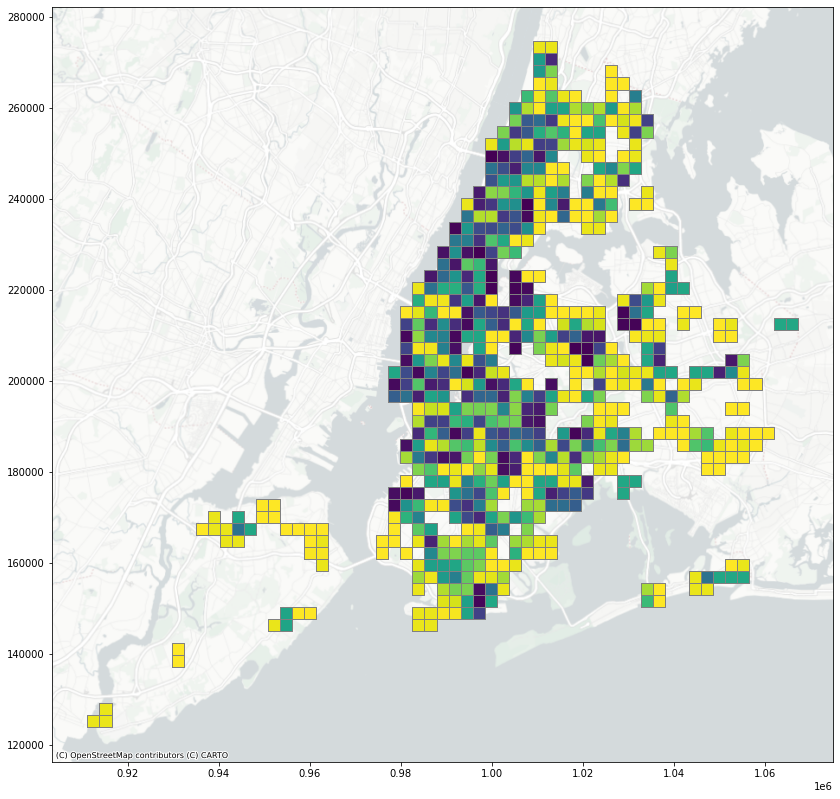

In [66]:
ax = r.plot(figsize = (14,14), column='prob', cmap='viridis', edgecolor='grey')
z = cx.add_basemap(ax, crs=r.crs, source=cx.providers.CartoDB.PositronNoLabels)
matplotlib.pyplot.savefig(fn, format="png")

In [39]:
start_year = start_date[:4]
end_year = end_date[:4]
start_month = start_date[5:7]
end_month = end_date[5:7]
start_day = start_date[-2:]
end_day = end_date[-2:]
# print(start_year, start_month, start_day)
start_dt = datetime.date(int(start_year), int(start_month), int(start_day))
end_dt = datetime.date(int(end_year), int(end_month), int(end_day))
# print(start_dt, end_dt)

2019-05-01 2019-12-31


In [42]:
df_mc.iloc[336412]

events       84.0
cst         129.0
 counts       1.0
cp            1.0
cs          686.0
ct          691.0
Name: 336412, dtype: float64

In [43]:
# create dataframe of cs, ct, cst and their probability according to mc distribution
mc_cs_ct_cst_df = df_mc[['cs', 'ct', 'cst', 'cp']].copy()

In [44]:
mc_cs_ct_cst_df

,cs,ct,cst,cp
0,0,0,0,1.0000
1,0,1,0,0.9968
2,0,2,0,0.9858
3,0,3,0,0.9754
4,0,4,0,0.9706
...,...,...,...,...
916189,7149,3828,1464,0.0010
916190,7198,3809,1467,0.0008
916191,6959,4003,1473,0.0006
916192,7357,3889,1517,0.0004


In [45]:
# convert cs, ct, cst columns from mc to numpy array
mc_cs_ct_cst_arr = mc_cs_ct_cst_df[['cs', 'ct', 'cst']].to_numpy()

In [46]:
mc_cs_ct_cst_arr

array([[   0,    0,    0],
       [   0,    1,    0],
       [   0,    2,    0],
       ...,
       [6959, 4003, 1473],
       [7357, 3889, 1517],
       [7967, 3868, 1596]], dtype=int64)

In [47]:
# make a kd-tree of the mc numpy array
kdt_mc = KDTree(mc_cs_ct_cst_arr)

In [76]:
kdt_mc.query([0, 0, 0])

(0.0, 0)

In [48]:
mc_cs_ct_cst_arr[64410]

array([ 88, 114,  26], dtype=int64)

In [75]:
mc_cs_ct_cst_df.iloc[64410]

cs      88.0000
ct     114.0000
cst     26.0000
cp       0.2672
Name: 64410, dtype: float64

In [134]:
grid_prob.loc[2,"test"] = 10

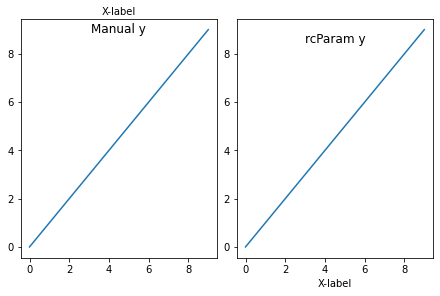

In [7]:
fig, axs = matplotlib.pyplot.subplots(1, 2, constrained_layout=True)

ax = axs[0]
ax.plot(range(10))
ax.xaxis.set_label_position('top')
ax.set_xlabel('X-label')
ax.set_title('Manual y', y=1.0, pad=-14)

matplotlib.pyplot.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
matplotlib.pyplot.rcParams['axes.titlepad'] = -24  # pad is in points...
ax = axs[1]
ax.plot(range(10))
ax.set_xlabel('X-label')
ax.set_title('rcParam y')

matplotlib.pyplot.show()